L’obiettivo del progetto **è esplorare e valutare le capacità di un Large Language Model (LLM)**, nello specifico Mistral-7B-Instruct-v0.2, nell’affrontare e risolvere problemi matematici di varia difficoltà.

Le stregie di prompting implementate sono:


*   Chain-of-Thought
*   Zero-shot
*   Iterative
*   Few_shot





Il primo passaggio prevede l'installazione delle librerie necessarie.

In [1]:
!pip install -U datasets
!pip install torch
!pip install transformers
!pip install -U datasets fsspec huggingface_hub
!pip install accelerate matplotlib pandas --quiet
!pip install bitsandbytes accelerate
!pip install -U bitsandbytes
!pip install tqdm seaborn sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
from datasets import load_dataset
import torch
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from random import seed
from collections import Counter

Carico il modello e memorizzo il token HuggingFace. Imposto il dispositivo su cui eseguire il modello e definisco il nome dei modelli. In questo caso useremo Mistral sia per la generazione delle risposte sia come giudice.



In [3]:
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
JUDGE_MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"


from google.colab import userdata


HF_TOKEN = userdata.get('HF_TOKEN')

Questa cella si occupa di configurare la quantizzazione a 4 bit per il modello di intelligenza artificiale. La quantizzazione è una tecnica che permette di ridurre la quantità di memoria necessaria per eseguire modelli di grandi dimensioni, senza perdere troppa precisione nei calcoli. In particolare, si utilizza la libreria bitsandbytes per abilitare il caricamento del modello in formato 4-bit. Viene inoltre abilitata la doppia quantizzazione, una tecnica avanzata che migliora ulteriormente la compressione dei dati. Per i calcoli viene scelto il tipo di dato bfloat16, che consente di risparmiare memoria mantenendo una buona precisione numerica. sono presenti opzioni aggiuntive per gestire situazioni in cui la memoria della GPU non è sufficiente.

In [4]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True,
    llm_int8_threshold=6.0
)

Il modello viene caricato con la configurazione di quantizzazione a 4 bit impostata in precedenza, ottimizzando così l’uso della memoria e delle risorse hardware.Vengono create due pipeline: una per generare le risposte (llm) e una per valutarle (judge), entrambe basate sullo stesso modello.


In [5]:
def load_llm(model_name, hf_token=None):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=hf_token)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype="auto",
        quantization_config=bnb_config,
        device_map="auto",
        use_auth_token=hf_token
    )
    return pipeline("text-generation", model=model, tokenizer=tokenizer)

llm = load_llm(MODEL_NAME, HF_TOKEN)
judge = load_llm(JUDGE_MODEL_NAME, HF_TOKEN)


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:935: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:935: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


Viene definita una funzione, load_gsm8k, che utilizza la libreria Hugging Face Datasets per scaricare il dataset. In questo caso utilizziamo GSM8K, che contiene problemi matematici di tipo aritmetico, tipici della scuola primaria e secondaria. Dopo aver caricato il dataset, stampiamo il primo esempio per mostrare come sono strutturati i dati.

In [6]:
def load_gsm8k():
    ds = load_dataset("gsm8k", "main")
    return ds['test']

dataset = load_gsm8k()

print(dataset[0])

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

{'question': "Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?", 'answer': 'Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.\nShe makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.\n#### 18'}


La funzione **classifica_problema** prende in input una domanda così da poter etichettare ogni problema. Viene verificata la presenza di termini che saranno presumibilmente presenti nei problemi relativi alle varie operazioni e si procede con un'etichettatura automatica.

In [7]:
def classifica_problema(q):
    q = q.lower()
    if any(w in q for w in ["add", "sum", "plus", "total", "in all", "altogether"]):
        return "addizione"
    elif any(w in q for w in ["subtract", "difference", "minus", "less than", "remain"]):
        return "sottrazione"
    elif any(w in q for w in ["multiply", "times", "product", "each", "per"]):
        return "moltiplicazione"
    elif any(w in q for w in ["half", "third", "fraction", "split", "divide", "each gets"]):
        return "frazione"
    elif any(w in q for w in ["if", "then", "not", "only if", "must", "logic"]):
        return "logica"
    else:
        return "altro"

**Genera_cot** è la funzione tramite la quale iniziamo a definire le strategie di prompting che saranno utilizzate. Definiamo inizialmente CoT fornendo un prompt guida, procediamo con la definizione di prompt Iterative, anche in questo caso forniamo una guida ma meno dettagliata

In [8]:
def genera_cot(domanda, model_pipeline, variation="cot"):
    if variation == "cot":
        prompt = f"""Solve the following math problem step by step.
                      For each step, write the calculation and explain your reasoning.
                      Do not skip any step.
                      At the end, write the final answer after '####'.
                      Double-check your calculations before writing the final answer.
                      Problem: {domanda}"""
    elif variation == "iterative":
        prompt = f"Think about the problem carefully and explain each step. {domanda}"
    else:
        prompt = domanda

    output = model_pipeline(prompt, max_new_tokens=512, do_sample=True, temperature=0.3)[0]['generated_text']
    return output[len(prompt):].strip()

def genera_senza_cot(domanda, model_pipeline):
    return genera_cot(domanda, model_pipeline, variation="no_cot")

Qui iniziamo a definire un'altra strategia di prompting: few shot, tramite la quale forniamo al modello degli esempi di cui potrà tenere conto per la risoluzione dei problemi.

In [9]:
few_shot_examples = [
 # Addizione
    {
        "question": "Julia has 7 apples and buys 5 more. How many apples does she have in total?",
        "solution": "Julia starts with 7 apples.\nShe buys 5 more.\n7 + 5 = 12 apples.\n#### 12"
    },
    # Sottrazione
    {
        "question": "Marco had 20 euros. He spends 8 euros on a book. How many euros does he have left?",
        "solution": "Marco starts with 20 euros.\nHe spends 8 euros.\n20 - 8 = 12 euros.\n#### 12"
    },
    # Moltiplicazione
    {
        "question": "A box contains 6 packets and each packet has 4 cookies. How many cookies are there in total?",
        "solution": "Each package has 4 cookies.\nThere are 6 packages.\n4 * 6 = 24 cookies.\n#### 24"
    },
    # Frazione
    {
        "question": "One liter of juice is divided equally between 4 glasses. How many liters of juice are in each glass?",
        "solution": "One liter is divided between 4 glasses.\n1 / 4 = 0.25 liters per glass.\n#### 0.25"
    },
    # Logica
    {
        "question": "If Marco has 4 pens and Giulio has 5 pens. How many pencils does Marco have?",
        "solution": "Marco has 4 pens. Giulio has 5 pens. No pencils are mentioned. Marco does not have any pencils."
    }
]

In [10]:
def genera_few_shot(domanda, model_pipeline, examples=few_shot_examples):
    prompt = ""
    for ex in examples:
        prompt += f"Q: {ex['question']}\nA: {ex['solution']}\n\n"
    prompt += f"Q: {domanda}\nA:"
    output = model_pipeline(prompt, max_new_tokens=512, do_sample=True, temperature=0.3)[0]['generated_text']
    return output[len(prompt):].strip()

La funzione estrai_risposta finale permette di estrarre la risposta numerica finale dall'output. Inizialmente forniamo alcune espressioni che potrebbero essere presenti per permette il riconoscimento della risposta finale, qualora non fosse efficiente suggeriamo di ricercare tutti i numeri nel testo. ### è il formato utilizzato da GSM8K.

La funzione parse_solution, invece, ci permette di estrarre gli step utilizzati per la risoluzione del problema e la risposta numerica generata.

In [11]:
def estrai_risposta_finale(output):
    #'Risposta finale: <numero>'
    match = re.search(r"Risposta finale:\s*([\d\.,-]+)", output)
    if match:
        return match.group(1).replace(",", ".").strip()
    # '#### <numero>'
    match = re.search(r"####\s*([\d\.,-]+)", output)
    if match:
        return match.group(1).replace(",", ".").strip()
    # 'Risposta: <numero>'
    match = re.search(r"Risposta:\s*([\d\.,-]+)", output)
    if match:
        return match.group(1).replace(",", ".").strip()
    # 'risposta è: <numero>'
    match = re.search(r"La risposta è:\s*([\d\.,-]+)", output)
    if match:
        return match.group(1).replace(",", ".").strip()
    # percentuali
    match = re.search(r"([\d\.,-]+)%", output)
    if match:
        return match.group(1).replace(",", ".").strip()
    # ultimo numero nel testo
    numeri = re.findall(r"[-+]?\d*\.?\d+", output)
    return numeri[-1] if numeri else None

def parse_solution(solution):
    match_gsm8k = re.search(r"(.*)####\s*([\d\.,-]+)", solution, re.DOTALL)
    if match_gsm8k:
        explanation = match_gsm8k.group(1).strip()
        answer = match_gsm8k.group(2).replace(",", ".").strip()
        steps = [step.strip() for step in explanation.split('\n') if step.strip()]
        return steps, answer
    final_answer = estrai_risposta_finale(solution)
    steps = [step.strip() for step in solution.split('\n') if step.strip()]
    return steps, final_answer

Procediamo con la valutazione automatica del ragionamento CoT utilizzando il modello giudice, in questo caso continuiamo a utilizzare Minstral. Forniamo un prompt che indica i criteri da tenere in considerazione per la valutazione, e quindi: Logica, Accuratezza matematica, completezza e chiarezza. Inoltre, chiediamo la restituzione di un punteggio che vada da 1 a 5.

In [12]:
def valuta_ragionamento_cot(cot_output, risposta_attesa, risposta_generata, giudice_pipeline):
    prompt = (
        f"You are an expert in evaluating mathematical reasoning produced by language models.\n\n"
        f"Your task is to assess the quality of a step-by-step reasoning process (Chain of Thought) used to solve a math problem.\n\n"
        f"Details:\n"
        f"Original Problem: [Included in the model's output]\n"
        f"Generated Reasoning:\n{cot_output}\n\n"
        f"Expected Answer: {risposta_attesa}\n"
        f"Model's Final Answer: {risposta_generata}\n\n"
        f"Please evaluate the generated reasoning based on the following criteria:\n"
        f"1. Logic: Does the reasoning follow a coherent and logical progression?\n"
        f"2. Mathematical Accuracy: Are the calculations and operations performed correctly in each step?\n"
        f"3. Completeness: Does the reasoning include all necessary steps to arrive at the solution?\n"
        f"4. Clarity: Is the reasoning easy to read and understand?\n\n"
        f"Provide an overall score from 1 (very poor) to 5 (excellent), and include a brief justification for your rating.\n\n"
        f"Output Format:\n"
        f"Score: [1 to 5]\n"
        f"Justification: [Short explanation of the score and reasoning behind the evaluation]"
    )
    output = giudice_pipeline(prompt, max_new_tokens=512, do_sample=False)[0]['generated_text']
    score_match = re.search(r"Score:\s*([1-5])", output)
    justification_match = re.search(r"Justification:\s*(.*)", output, re.DOTALL)

    punteggio = int(score_match.group(1)) if score_match else None
    giustificazione = justification_match.group(1).strip() if justification_match else output.strip()

    return punteggio, giustificazione

Applichiamo la self-consistency per verificare la coerenza delle risposte generate. In questo caso, saranno considerate le risposte apparse un maggior numero di volte.

In [13]:
def apply_self_consistency(generated_responses):
    extracted_answers = [estrai_risposta_finale(r) for r in generated_responses if estrai_risposta_finale(r)]
    if not extracted_answers:
        return None
    return Counter(extracted_answers).most_common(1)[0][0]

Qui si ha la vera e propria applicazione delle strategie precedentemente definite. Si estrae la domanda, si classifica il problema e si genera la risposta utilizzando CoT, Iterative, Few-shot e No Cot. Si applica la self-consistency alla risposta generata e si procede calcolando l'accuracy sulla risposta corretta dopo l'applicazione di self-consistency. Otterrò quattro file: uno per ogni strategia. Ogni file conterrà:
- la domanda
- la categoria del problema
- la risposta attesa
- la risposta generata
- la risposta ottenuta tramite self-consistency
- l'accuracy della risposta estratta con self-consistency (True-False)
- il testo completo della prima risposta generata
- la prima risposta generata
- l'accuracy della prima risposta,


Utilizzo la funzione abs per estrarre il valore assoluto così da capire qual è la distanza tra il valore reale e quello generato.

In [14]:
def esegui_test(dataset, model_pipeline, variation="cot", num_samples=100, num_generations=1):
    risultati = []
    subset = dataset.shuffle(seed=42).select(range(min(num_samples, len(dataset))))
    for esempio in tqdm(subset, desc=f"Esecuzione test ({variation})", unit="esempio"):
        domanda = esempio['question']
        risposta_attesa = estrai_risposta_finale(str(esempio['answer']))
        categoria = classifica_problema(domanda)
        generated_responses = []
        for _ in range(num_generations):
            if variation == "cot":
                output_raw = genera_cot(domanda, model_pipeline)
            elif variation == "iterative":
                output_raw = genera_cot(domanda, model_pipeline, variation="iterative")
            elif variation == "few_shot":
                output_raw = genera_few_shot(domanda, model_pipeline)
            else:
                output_raw = genera_senza_cot(domanda, model_pipeline)
            generated_responses.append(output_raw)
        risposta_generata_sc = apply_self_consistency(generated_responses)
        try:
            accuracy_sc = (abs(float(risposta_generata_sc) - float(risposta_attesa)) < 1e-3) or (int(round(float(risposta_generata_sc))) == int(round(float(risposta_attesa))))
        except:
            accuracy_sc = False
        first_output_raw = generated_responses[0] if generated_responses else ""
        risposta_generata_first = estrai_risposta_finale(first_output_raw)
        try:
            accuracy_first_response = (abs(float(risposta_generata_first) - float(risposta_attesa)) < 1e-3) or (int(round(float(risposta_generata_first))) == int(round(float(risposta_attesa))))
        except:
            accuracy_first_response = False
        risultati.append({
            "domanda": domanda,
            "categoria": categoria,
            "risposta_attesa": risposta_attesa,
            "generated_responses": generated_responses,
            "risposta_generata_sc": risposta_generata_sc,
            "accuracy_sc": accuracy_sc,
            "raw_first_response": first_output_raw,
            "risposta_generata_first": risposta_generata_first,
            "accuracy_first_response": accuracy_first_response
        })
    return risultati

def salva_risultati(risultati, path):
    with open(path, "w") as f:
        json.dump(risultati, f, indent=2)

In [ ]:

risultati_cot = esegui_test(dataset, llm, variation="cot", num_samples=100, num_generations=1)
salva_risultati(risultati_cot, "results_cot.json")

risultati_iter = esegui_test(dataset, llm, variation="iterative", num_samples=100, num_generations=1)
salva_risultati(risultati_iter, "results_iterative.json")

risultati_no_cot = esegui_test(dataset, llm, variation="no_cot", num_samples=100, num_generations=1)
salva_risultati(risultati_no_cot, "results_no_cot.json")

risultati_few_shot = esegui_test(dataset, llm, variation="few_shot", num_samples=100, num_generations=1)
salva_risultati(risultati_few_shot, "results_few_shot.json")


risultati_cot_sc = esegui_test(dataset, llm, variation="cot", num_samples=100, num_generations=3)
salva_risultati(risultati_cot_sc, "results_cot_sc.json")

Esecuzione test (cot):  10%|█         | 10/100 [04:08<39:01, 26.02s/esempio]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Esecuzione test (cot):   0%|          | 0/100 [00:00<?, ?esempio/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Esecuzione test (cot):   1%|          | 1/100 [01:26<2:23:07, 86.74s/esempio]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Esecuzione test (cot):   2%|▏         | 2/100 [02:48<2:16:48, 83.76s/esempio]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for ope

Converto i dati salvati nei rispettivi file in dataframe per calcolare una media dei risultati ottenuti per ogni strategia e rappresento graficamente i valori.

Accuratezza Media Zero-shot: 0.35
Accuratezza Media CoT: 0.46
Accuratezza Media Iterative: 0.38
Accuratezza Media Few-shot: 0.35
Accuratezza Media CoT Self-Consistency: 0.41


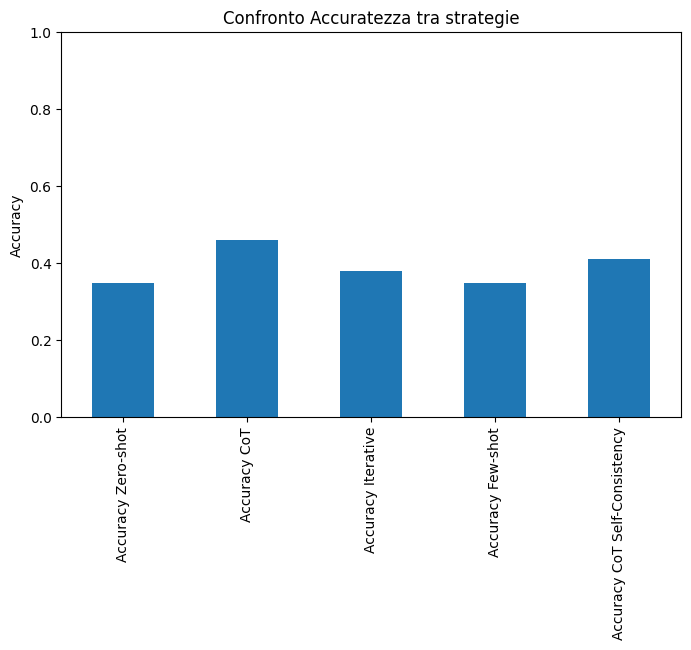

In [ ]:

def carica_risultati(path):
    with open(path, "r") as f:
        return json.load(f)

df_cot = pd.DataFrame(carica_risultati("results_cot.json"))
df_iter = pd.DataFrame(carica_risultati("results_iterative.json"))
df_no_cot = pd.DataFrame(carica_risultati("results_no_cot.json"))
df_few_shot = pd.DataFrame(carica_risultati("results_few_shot.json"))
df_cot_sc = pd.DataFrame(carica_risultati("results_cot_sc.json"))


df_cot = df_cot.rename(columns={'accuracy_first_response': 'Accuracy CoT'})
df_iter = df_iter.rename(columns={'accuracy_first_response': 'Accuracy Iterative'})
df_no_cot = df_no_cot.rename(columns={'accuracy_first_response': 'Accuracy Zero-shot'})
df_few_shot = df_few_shot.rename(columns={'accuracy_first_response': 'Accuracy Few-shot'})
df_cot_sc = df_cot_sc.rename(columns={'accuracy_sc': 'Accuracy CoT Self-Consistency'})


df_results = df_no_cot[['domanda', 'risposta_attesa', 'Accuracy Zero-shot']].merge(
    df_cot[['domanda', 'Accuracy CoT']], on='domanda'
).merge(
    df_iter[['domanda', 'Accuracy Iterative']], on='domanda'
).merge(
    df_few_shot[['domanda', 'Accuracy Few-shot']], on='domanda'
).merge(
    df_cot_sc[['domanda', 'Accuracy CoT Self-Consistency']], on='domanda'
)

# Accuratezze medie per ogni strategia utilizzata
print("Accuratezza Media Zero-shot:", df_results['Accuracy Zero-shot'].mean())
print("Accuratezza Media CoT:", df_results['Accuracy CoT'].mean())
print("Accuratezza Media Iterative:", df_results['Accuracy Iterative'].mean())
print("Accuratezza Media Few-shot:", df_results['Accuracy Few-shot'].mean())
print("Accuratezza Media CoT Self-Consistency:", df_results['Accuracy CoT Self-Consistency'].mean())


plt.figure(figsize=(8,5))
df_results[['Accuracy Zero-shot', 'Accuracy CoT', 'Accuracy Iterative', 'Accuracy Few-shot', 'Accuracy CoT Self-Consistency']].mean().plot(kind='bar')
plt.title('Confronto Accuracy tra strategie')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()